In [76]:
#!/usr/bin/env python

import matplotlib.pyplot as plt
import numpy as np


def visualize_trajectory(trajectory):
    ax = plt.figure().add_subplot(projection='3d')
    cumulative_time = 0
    for i, poly in enumerate(trajectory.polynomials):
        d = poly.duration
        time_segment = np.linspace(cumulative_time, cumulative_time + d, int(10 * d))
        print(cumulative_time)
        cumulative_time += d
        output = [poly.eval(t) for t in time_segment]
        x = [o.pos[0] for o in output]
        y = [o.pos[1] for o in output]
        z = [o.pos[2] for o in output]
        ax.plot(x, y, z, label=i)
    ax.legend()
    plt.show()

def get_values_of_functions(f_x=None, f_y=None, f_z=None, f_yaw=None, domain=(0, 1)):
    t_vals = np.linspace(*domain, int(1000*(domain[1] - domain[0])))
    # Get the ground truth values
    if not (f_x is None):
        x_vals = f_x(t_vals)
    else:
        x_vals = np.zeros_like(t_vals)
    if not (f_y is None):
        y_vals = f_y(t_vals)
    else:
        y_vals = np.zeros_like(t_vals)
    if not (f_z is None):
        z_vals = f_z(t_vals)
    else:
        z_vals = np.zeros_like(t_vals)
    if not (f_yaw is None):
        yaw_vals = f_yaw(t_vals)
    else:
        yaw_vals = np.zeros_like(t_vals)

    return x_vals, y_vals, z_vals, yaw_vals, t_vals


def find_breakpoints(fx=None, fy=None, fz=None, fyaw=None, domain=(0, 1)):
    if fx is None:
        f_x = lambda x: np.zeros_like(x)
    else:
        f_x = lambda x: fx(x) - fx(domain[0])
    if fy is None:
        f_y = lambda x: np.zeros_like(x)
    else:
        f_y = lambda y: fy(y) - fy(domain[0])
    if fz is None:
        f_z = lambda x: np.zeros_like(x)
    else:
        f_z = lambda z: fz(z) - fz(domain[0])
    if fyaw is None:
        f_yaw = lambda x: np.zeros_like(x)
    else:
        f_yaw = lambda yaw: fyaw(yaw) - fyaw(domain[0])
    x, y, z, yaw, t = get_values_of_functions(f_x=f_x, f_y=f_y, f_z=f_z, f_yaw=f_yaw, domain=domain)
    n_breakpoints = 16 # n segments = n_breakpoints + 1
    best_error = 1e10
    # trials for uniform guesses, take the best outcome
    for i in range(100):
        breaks = np.random.uniform(*domain, n_breakpoints)
        breaks = np.sort(breaks)
        breaks = np.append(breaks, domain[1])
        breaks = np.insert(breaks, 0, domain[0])
        tp_x, tp_y, tp_z, tp_yaw = [], [], [], []
        error = 0
        for i in range(1, len(breaks)):
            midpoint = breaks[i - 1] + (breaks[i] - breaks[i-1]) / 2
            segment = np.where(np.logical_and(t > breaks[i-1], t < breaks[i]))[0]
            if len(segment) <= 8:
                continue
            approx_x = np.polynomial.polynomial.Polynomial.fit(t[segment], x[segment], deg=7).convert()
            approx_y = np.polynomial.polynomial.Polynomial.fit(t[segment], y[segment], deg=7).convert()
            approx_z = np.polynomial.polynomial.Polynomial.fit(t[segment], z[segment], deg=7).convert()
            approx_yaw = np.polynomial.polynomial.Polynomial.fit(t[segment], yaw[segment], deg=7).convert()
            tp_x.append(approx_x)
            tp_y.append(approx_y)
            tp_z.append(approx_z)
            tp_yaw.append(approx_yaw)
            error += np.linalg.norm(approx_x(t[segment]) - x[segment])
            error += np.linalg.norm(approx_y(t[segment]) - y[segment])
            error += np.linalg.norm(approx_z(t[segment]) - z[segment])
            error += np.linalg.norm(approx_yaw(t[segment]) - yaw[segment])
        if (len(tp_x) != n_breakpoints + 1):
            continue
        if error < best_error:
            best_error = error
            best_x = tp_x
            best_y = tp_y
            best_z = tp_z
            best_yaw = tp_yaw
            breakpoints = breaks
        if best_error == 0:
            break
    return best_x, best_y, best_z, best_yaw, breakpoints



def auto_trajectory(f_x=None, f_y=None, f_z=None, f_yaw=None, domain=(0, 1)):
    """
    :param f_x: callable function f_x(t), which maps time to x-position
    :param f_y: callable function f_y(t), which maps time to y-position
    :param f_z: callable function f_z(t), which maps time to z-position
    :param f_yaw: callable function f_yaw(t), which maps time to yaw
    :param domain: the values that t takes on in the given functions
    :param num_trajectories: the number of trajectories to divide the approximations into (the more trajectories, the more accurate the approximation)

    :return: returns num_trajectories Trajectory objects that attempt to closely the original functions given.
    """
    # TODO: make better than uniform random...

    assert domain[1] > domain[0]

    approx_x, approx_y, approx_z, approx_yaw, breaks = find_breakpoints(f_x, f_y, f_z, f_yaw, domain)
    print(breaks)
    trajectory = Trajectory()
    trajectory.polynomials = []
    for i, (x, y, z, yaw, duration) in enumerate(zip(approx_x, approx_y, approx_z, approx_yaw, breaks)):
        x = np.array(list(x.coef))
        y = np.array(list(y.coef))
        z = np.array(list(z.coef))
        yaw = np.array(list(yaw.coef))
        while len(x) < 8:
            x = np.append(x, 0)
        while len(y) < 8:
            y = np.append(y, 0)
        while len(z) < 8:
            z = np.append(z, 0)
        while len(yaw) < 8:
            yaw = np.append(yaw, 0)
        poly = Polynomial4D(breaks[i+1] - breaks[i], x, y, z, yaw)
        print("duration", breaks[i+1] - breaks[i])
        trajectory.polynomials.append(poly)

    trajectory.duration = domain[1] - domain[0]
    print(domain[1] - domain[0])
    visualize_trajectory(trajectory)
    return trajectory

def normalize(v):
    norm = np.linalg.norm(v)
    assert norm > 0
    return v / norm


class Polynomial:
    def __init__(self, p):
        self.p = p

    # evaluate a polynomial using horner's rule
    def eval(self, t):
        assert t >= 0
        x = 0.0
        for i in range(0, len(self.p)):
            x = x * t + self.p[len(self.p) - 1 - i]
        return x

    # compute and return derivative
    def derivative(self):
        return Polynomial([(i+1) * self.p[i+1] for i in range(0, len(self.p) - 1)])


class TrajectoryOutput:
    def __init__(self):
        self.pos = None   # position [m]
        self.vel = None   # velocity [m/s]
        self.acc = None   # acceleration [m/s^2]
        self.omega = None # angular velocity [rad/s]
        self.yaw = None   # yaw angle [rad]


# 4d single polynomial piece for x-y-z-yaw, includes duration.
class Polynomial4D:
    def __init__(self, duration, px, py, pz, pyaw):
        self.duration = duration
        self.px = Polynomial(px)
        self.py = Polynomial(py)
        self.pz = Polynomial(pz)
        self.pyaw = Polynomial(pyaw)

    # compute and return derivative
    def derivative(self):
        return Polynomial4D(
            self.duration,
            self.px.derivative().p,
            self.py.derivative().p,
            self.pz.derivative().p,
            self.pyaw.derivative().p)

    def eval(self, t):
        result = TrajectoryOutput()
        # flat variables
        result.pos = np.array([self.px.eval(t), self.py.eval(t), self.pz.eval(t)])
        result.yaw = self.pyaw.eval(t)

        # 1st derivative
        derivative = self.derivative()
        result.vel = np.array([derivative.px.eval(t), derivative.py.eval(t), derivative.pz.eval(t)])
        dyaw = derivative.pyaw.eval(t)

        # 2nd derivative
        derivative2 = derivative.derivative()
        result.acc = np.array([derivative2.px.eval(t), derivative2.py.eval(t), derivative2.pz.eval(t)])

        # 3rd derivative
        derivative3 = derivative2.derivative()
        jerk = np.array([derivative3.px.eval(t), derivative3.py.eval(t), derivative3.pz.eval(t)])

        thrust = result.acc + np.array([0, 0, 9.81]) # add gravity

        z_body = normalize(thrust)
        x_world = np.array([np.cos(result.yaw), np.sin(result.yaw), 0])
        y_body = normalize(np.cross(z_body, x_world))
        x_body = np.cross(y_body, z_body)

        jerk_orth_zbody = jerk - (np.dot(jerk, z_body) * z_body)
        h_w = jerk_orth_zbody / np.linalg.norm(thrust)

        result.omega = np.array([-np.dot(h_w, y_body), np.dot(h_w, x_body), z_body[2] * dyaw])
        return result


class Trajectory:
    def __init__(self):
        self.polynomials = None
        self.duration = None

    def n_pieces(self):
        return len(self.polynomials)

    def loadcsv(self, filename):
        data = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=range(33))
        self.polynomials = [Polynomial4D(row[0], row[1:9], row[9:17], row[17:25], row[25:33]) for row in data]
        self.duration = np.sum(data[:,0])

    def savecsv(self, filename):
        data = np.empty((len(self.polynomials), 8*4+1))
        for i, p in enumerate(self.polynomials):
            data[i,0] = p.duration
            data[i,1:9] = p.px.p
            data[i,9:17] = p.py.p
            data[i,17:25] = p.pz.p
            data[i,25:33] = p.pyaw.p
        np.savetxt(filename, data, fmt="%.6f", delimiter=",", header="duration,x^0,x^1,x^2,x^3,x^4,x^5,x^6,x^7,y^0,y^1,y^2,y^3,y^4,y^5,y^6,y^7,z^0,z^1,z^2,z^3,z^4,z^5,z^6,z^7,yaw^0,yaw^1,yaw^2,yaw^3,yaw^4,yaw^5,yaw^6,yaw^7")


    def eval(self, t):
        assert t >= 0
        assert t <= self.duration

        current_t = 0.0
        for p in self.polynomials:
            if t <= current_t + p.duration:
                return p.eval(t - current_t)
            current_t = current_t + p.duration



In [77]:

import scipy.optimize


# computes the difference between current interpolation and desired values
def func(coefficients, times, values, piece_length):
    result = 0
    i = 0
    for t, value in zip(times, values):
        if t > (i + 1) * piece_length:
            i = i + 1
        estimate = np.polyval(coefficients[i * 8:(i + 1) * 8],
                              t - i * piece_length)
        # print(coefficients[i*8:(i+1)*8], t - i * piece_length, estimate)
        result += (value - estimate) ** 2  # np.sum((values - estimates) ** 2)
    # print(coefficients, result)
    return result


# constraint to match values between spline pieces
# def func_eq_constraint_val(coefficients, i, piece_length):
#     result = 0
#     end_val = np.polyval(coefficients[(i - 1) * 8:i * 8], piece_length)
#     start_val = np.polyval(coefficients[i * 8:(i + 1) * 8], 0)
#     return end_val - start_val


def func_eq_constraint_der(coefficients, i, piece_length, order):
    result = 0
    last_der = np.polyder(coefficients[(i - 1) * 8:i * 8], order)
    this_der = np.polyder(coefficients[i * 8:(i + 1) * 8], order)

    end_val = np.polyval(last_der, piece_length)
    start_val = np.polyval(this_der, 0)
    return end_val - start_val


def func_eq_constraint_der_value(coefficients, i, t, desired_value, order):
    result = 0
    der = np.polyder(coefficients[i * 8:(i + 1) * 8], order)

    value = np.polyval(der, t)
    return value - desired_value


# def func_eq_constraint(coefficients, tss, yawss):
#   result = 0
#   last_derivative = None
#   for ts, yaws, i in zip(tss, yawss, range(0, len(tss))):
#     derivative = np.polyder(coefficients[i*8:(i+1)*8])
#     if last_derivative is not None:
#       result += np.polyval(derivative, 0) - last_derivative
#     last_derivative = np.polyval(derivative, tss[-1])
#
#
# # apply coefficients to trajectory
# for i,p in enumerate(traj.polynomials):
#   p.pyaw.p = coefficients[i*8:(i+1)*8]
# # evaluate at each timestep and compute the sum of squared differences
# result = 0
# for t,yaw in zip(ts,yaws):
#   e = traj.eval(t)
#   result += (e.yaw - yaw) ** 2
# return result

def generate_trajectory_from_file(filename, num_pieces=5, approx=False):
    data = np.loadtxt(filename, delimiter=',', skiprows=1)
    return generate_trajectory(data, num_pieces, approx)


def generate_trajectory(data, num_pieces, approx=False):
    piece_length = data[-1, 0] / num_pieces
    # print(piece_length)
    x0 = np.zeros(num_pieces * 8)

    constraints = []
    # piecewise values and derivatives have to match
    for i in range(1, num_pieces):
        for order in range(0, 4):
            if approx:
                constraints.append({'type': 'ineq',
                                    'fun': lambda coef, i, p, l: np.abs(
                                        func_eq_constraint_der(coef, i, p,
                                                               l)) - 0.0005,
                                    'args': (i, piece_length, order)})
                # constraints.append({'type': 'ineq', 'fun': lambda coef, i, p, l: -func_eq_constraint_der(coef, i, p, l) - 0.0005, 'args': (i, piece_length, order)})
                # constraints.append({'type': 'eq', 'fun': func_eq_constraint_der, 'ub': 0.005, 'lb': 0.005, 'args': (i, piece_length, order)})
            else:
                constraints.append({'type': 'eq', 'fun': func_eq_constraint_der,
                                    'args': (i, piece_length, order)})

    # zero derivative at the beginning and end
    for order in range(1, 3):
        constraints.append({'type': 'eq', 'fun': func_eq_constraint_der_value,
                            'args': (0, 0, 0, order)})
        constraints.append({'type': 'eq', 'fun': func_eq_constraint_der_value,
                            'args': (num_pieces - 1, piece_length, 0, order)})

    # print("fitting x")
    resX = scipy.optimize.minimize(func, x0,
                                   (data[:, 0], data[:, 1], piece_length),
                                   method="SLSQP", options={"maxiter": 100},
                                   constraints=constraints
                                   )
    # print("fitting y")
    resY = scipy.optimize.minimize(func, x0,
                                   (data[:, 0], data[:, 2], piece_length),
                                   method="SLSQP", options={"maxiter": 100},
                                   constraints=constraints
                                   )
    # print("fitting z")
    resZ = scipy.optimize.minimize(func, x0,
                                   (data[:, 0], data[:, 3], piece_length),
                                   method="SLSQP", options={"maxiter": 100},
                                   constraints=constraints
                                   )

    resYaw = scipy.optimize.minimize(func, x0,
                                     (data[:, 0], data[:, 4], piece_length),
                                     method="SLSQP", options={"maxiter": 100},
                                     constraints=constraints
                                     )

    traj = Trajectory()
    traj.polynomials = [Polynomial4D(
        piece_length,
        np.array(resX.x[i * 8:(i + 1) * 8][::-1]),
        np.array(resY.x[i * 8:(i + 1) * 8][::-1]),
        np.array(resZ.x[i * 8:(i + 1) * 8][::-1]),
        np.array(resYaw.x[i * 8:(i + 1) * 8][::-1])) for i in
        range(0, num_pieces)]
    traj.duration = data[-1, 0]
    return traj


def constant_traj(t):
    return 0


def generate_position_data(fx=constant_traj, fy=constant_traj, fz=constant_traj,
    fyaw=constant_traj, domain=(0, 1), output='test.csv'):
    t = np.linspace(*domain, int(
        domain[1] - domain[0]) * 30)  # 20 points per second to fit
    data = []
    with open(output, 'w') as f:
        f.write("t,x,y,z,yaw\n")

        for i in t:
            f.write("{},{},{},{},{}\n".format(i, fx(i), fy(i), fz(i), fyaw(i)))
            data.append((i, fx(i), fy(i), fz(i), fyaw(i)))
    return data

In [78]:
from matplotlib import gridspec


def plot(traj):
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3]  = e.pos
        evals[i, 3:6]  = e.vel
        evals[i, 6:9]  = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12]   = e.yaw
        #evals[i, 13]   = e.roll
        #evals[i, 14]   = e.pitch

    velocity = np.linalg.norm(evals[:,3:6], axis=1)
    acceleration = np.linalg.norm(evals[:,6:9], axis=1)
    omega = np.linalg.norm(evals[:,9:12], axis=1)

    # print stats
    print("max speed (m/s): ", np.max(velocity))
    print("max acceleration (m/s^2): ", np.max(acceleration))
    print("max omega (rad/s): ", np.max(omega))
    print("max roll (deg): ", np.max(np.degrees(evals[:,13])))
    print("max pitch (deg): ", np.max(np.degrees(evals[:,14])))

    # Create 3x1 sub plots
    gs = gridspec.GridSpec(6, 1)
    fig = plt.figure()

    ax = plt.subplot(gs[0:2, 0], projection='3d') # row 0
    ax.plot(evals[:,0], evals[:,1], evals[:,2])

    ax = plt.subplot(gs[2, 0]) # row 2
    ax.plot(ts, velocity)
    ax.set_ylabel("velocity [m/s]")

    ax = plt.subplot(gs[3, 0]) # row 3
    ax.plot(ts, acceleration)
    ax.set_ylabel("acceleration [m/s^2]")

    ax = plt.subplot(gs[4, 0]) # row 4
    ax.plot(ts, omega)
    ax.set_ylabel("omega [rad/s]")

    ax = plt.subplot(gs[5, 0]) # row 5
    ax.plot(ts, np.degrees(evals[:,12]))
    ax.set_ylabel("yaw [deg]")

    # ax = plt.subplot(gs[6, 0]) # row 5
    # ax.plot(ts, np.degrees(evals[:,13]))
    # ax.set_ylabel("roll [deg]")

    # ax = plt.subplot(gs[7, 0]) # row 5
    # ax.plot(ts, np.degrees(evals[:,14]))
    # ax.set_ylabel("pitch [deg]")

    plt.show()

In [79]:
from curves_to_trajectory import curves
def generate_test_data():
    fx, fy = curves.circle_facing_constant((1, 0), 10)
    print("Generating position data")
    generate_position_data(fx=fx, fy=fy,
                           domain=(0, 2 * np.pi),
                           output='position_data.csv')
    print("Generating trajectory")
    traj = generate_trajectory_from_file('position_data.csv')
    traj.savecsv('traj.csv')
    print("Plotting")
    plot(traj)

Generating position data
Generating trajectory
Plotting
max speed (m/s):  0.7959973666502355
max acceleration (m/s^2):  3.1097345965935443
max omega (rad/s):  5.146202060143204
max roll (deg):  5.27654033255827e-310
max pitch (deg):  5.27654033255827e-310


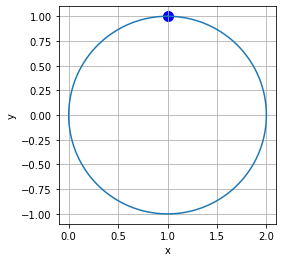

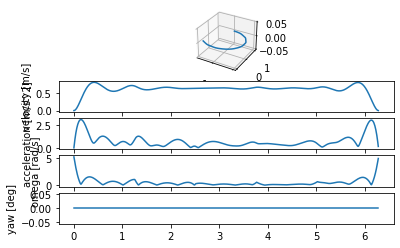

In [80]:
generate_test_data()